In [57]:
%matplotlib inline
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.gaussian_process import GaussianProcess
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.grid_search import RandomizedSearchCV
from pyearth import Earth
from copy import deepcopy
from sklearn.ensemble import partial_dependence as pd
from xgboost import XGBRegressor, XGBClassifier

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [16]:
dataset = np.load('data.npz')
X_full = dataset['X']
X_full = X_full.reshape((X_full.shape[0], -1))
y = dataset['nMCparticles']

In [58]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

imp = []

def train_and_get_results(reg, X_full, y, score_fn=r2_score, n_folds=5):
    X = X_full    
    folds = KFold(X.shape[0], n_folds=n_folds)
    scores_train = []
    scores_test = []
    models = []
    for train, test in folds:
        reg_ = clone(reg)

        m = y[train].mean()
        s = y[train].std()

        
        reg_.fit(X[train], (y[train]))

        score = score_fn(y[train], (reg_.predict(X[train])))
        scores_train.append(score)

        score = score_fn(y[test] , (reg_.predict(X[test])))
        scores_test.append(score)
        models.append(reg_)
        if hasattr(reg_, 'feature_importances_'):
            imp.append(reg_.feature_importances_)
    return scores_train, scores_test, models

rf_param_dist = {"max_depth": sp_randint(1, 100),
              "n_estimators": sp_randint(1, 100),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False]}
gb_params_dist= {
    "learning_rate": sp_uniform(0, 1), 
    "n_estimators": sp_randint(1, 200), 
    "max_depth": sp_randint(1, 100)
}
regs = [
    DummyClassifier(),
    #LinearRegression(),
    RandomForestClassifier(max_depth=30, n_estimators=50),
    XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, 
                  silent=True, objective='binary:logistic', nthread=-1, 
                  gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
                  colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, 
                  reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, 
                  missing=None)
]

In [ ]:
score_fn = accuracy_score

results = map(lambda reg:train_and_get_results(reg, X_full, y, score_fn=score_fn, n_folds=5), regs)

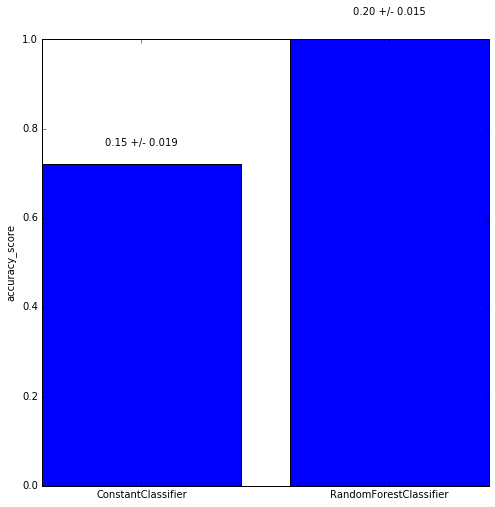

In [55]:
test_mean = np.array([np.mean(scores_test) for scores_train, scores_test, models in results])
test_std = np.array([np.std(scores_test) for scores_train, scores_test, models in results])

train_mean = [np.mean(scores_train) for scores_train, scores_test, models in results]
train_std = [np.std(scores_train) for scores_train, scores_test, models in results]

names = [reg.__class__.__name__.replace('Regressor', '').replace('Dummy', 'Constant') for reg in regs]
ind = np.arange(len(regs))

fig, ax = plt.subplots(figsize=(8, 8))

width = 0.8
plt.xticks(ind + width/2., names)
rects = plt.bar(ind, test_mean / test_mean.max(), width=width, color='blue')
for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05 * height,
            '%.2f +/- %.3f' % (test_mean[i], test_std[i] ),
             ha='center', va='bottom')
plt.ylabel('{}'.format(score_fn.__name__))